# Predict the stock market

### Set up

In [5]:
# Set un the environment
import pandas as pd
import numpy as np
import warnings
from matplotlib import pyplot
from pandas import Series, datetime
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import random
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import seaborn as sns
import nltk
import string
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from sklearn.preprocessing import FunctionTransformer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string

c:\users\henon\.venvs\lewagon\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  


## Preprocessing

In [2]:
from STOCK_PREDICT.data import Data

In [3]:
data = Data()

In [4]:
df, X_train, X_test, y_train, y_test = data.clean_df()

In [5]:
df.head(2)

,Date,Label,Subjectivity,Objectivity,Positive,Negative,Neutral,cleaned,Open,High,Low,Close,Volume,Adj Close,change,target
0,2008-08-08,0,75.00,25.00,18.75,56.25,25.00,georgia down two russian warplane country move...,11432.089844,11759.959961,11388.040039,11734.320312,212830000,11734.320312,-0.244438,0
1,2008-12-08,0,56.25,43.75,18.75,37.50,43.75,remember adorable year old sang opening ceremo...,8637.650391,9026.410156,8637.490234,8934.179688,358970000,8934.179688,0.346756,1


## Heatmap of features

In [ ]:
colormap = pyplot.cm.RdYlBu
pyplot.figure(figsize=(16,12))
pyplot.title('Pearson correlation of continuous features', y=1.05, size=15)
sns.heatmap(df.corr(),linewidths=0.1,vmax=1.0, square=True, 
            cmap=colormap, linecolor='white', annot=True)
pyplot.show()

In [ ]:
# Scale variables
#scaler = StandardScaler().fit(X_train)
#X_train = scaler.transform(X_train)
#X_test = scaler.transform(X_test)

## Machine Learning Modelling

In [7]:
import xgboost as xgb

In [8]:
scoring = 'precision'
# Append the models to the models list
models = []
models.append(('LR' , LogisticRegression()))
models.append(('LDA' , LinearDiscriminantAnalysis()))
models.append(('KNN' , KNeighborsClassifier()))
models.append(('CART' , DecisionTreeClassifier()))
models.append(('NB' , GaussianNB()))
models.append(('SVM' , SVC()))
models.append(('RF' , RandomForestClassifier(n_estimators=50)))
#models.append(('XGBoost', XGBClassifier()))

In [9]:
import warnings; warnings.simplefilter('ignore')

# Evaluate each algorithm for accuracy
results = []
names = []

for name, model in models:
    clf = model
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accu_score = accuracy_score(y_test, y_pred)
    print(name + ": " + str(accu_score))

LR: 0.5472061657032755
LDA: 0.7996146435452793
KNN: 0.4836223506743738
CART: 0.5298651252408478
NB: 0.5452793834296724
SVM: 0.5472061657032755
RF: 0.5394990366088632


In [10]:
import warnings; warnings.simplefilter('ignore')

for name, model in models:
    kfold = KFold(n_splits=10, random_state=42)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg) 

LR: 0.545055 (0.048822)
LDA: 0.761807 (0.090641)
KNN: 0.548695 (0.063023)
CART: 0.575829 (0.058592)
NB: 0.544261 (0.057943)
SVM: 0.546636 (0.048899)
RF: 0.560347 (0.051350)


### Linear Discriminant Analysis

In [38]:
model_lda = LinearDiscriminantAnalysis()
model_lda.fit(X_train, y_train)

# estimate accuracy on validation dataset
rescaledValidationX = scaler.transform(X_test)
predictions = model_lda.predict(X_test)
print("accuracy score:")
print(accuracy_score(y_test, predictions))

NameError: name 'scaler' is not defined

In [ ]:
y_pred_proba = model_lda.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
print("roc auc is :" + str(roc_auc))
pyplot.plot([0, 1], [0, 1], 'k--')
pyplot.plot(fpr, tpr)
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.title('ROC Curve')
pyplot.show()

# AUC score using cross validation
kfold_val = KFold(n_splits=10, random_state=42)
auc_score = cross_val_score(model_lda, X_test, y_test, cv=kfold_val, scoring='roc_auc')
print("AUC using cross val: " + str(auc_score))
mean_auc = np.mean(auc_score)
print("Mean AUC score is: " + str(mean_auc))

## XGBoost feature selection


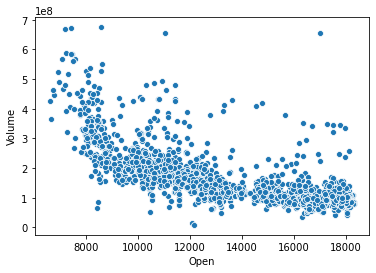

In [11]:
import seaborn as sns
ax = sns.scatterplot(x="Open", y="Volume", hue=None,data= df)

In [12]:
import xgboost as xgb

In [13]:
xg_reg = xgb.XGBClassifier(learning_rate = 0.1,
                          max_depth = 2, 
                          min_child_weight=17, 
                          n_estimators = 100, 
                          nthread=1, 
                          subsample=1.0)

In [14]:
xg_reg.fit(X_train,y_train)
preds = xg_reg.predict(X_test)
predictions = [round(value) for value in y_pred]

In [15]:
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 53.95%


# XGBoost with KFold

In [16]:
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [35]:
model = xgb.XGBClassifier(learning_rate = 0.3,
                          max_depth = 3, 
                          min_child_weight=19, 
                          n_estimators = 300, 
                          nthread=1, 
                          subsample=1.0)
kfold = KFold(n_splits=10, random_state=7)
results = cross_val_score(model, X_train, y_train, cv=kfold)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Accuracy: 58.14% (3.83%)


## LDA

In [36]:
clf = LinearDiscriminantAnalysis()
clf = clf.fit(X_train, y_train)
pred = clf.predict(X_test)
predictions = [round(value) for value in y_pred]

In [37]:
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 53.95%


## Mr. 0.94

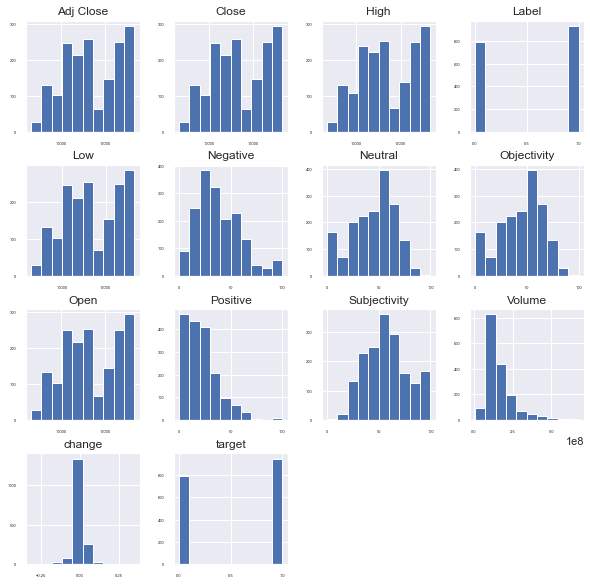

In [40]:
sns.set()
df.hist(sharex = False, sharey = False, xlabelsize = 4, ylabelsize = 4, figsize=(10, 10))
pyplot.show()

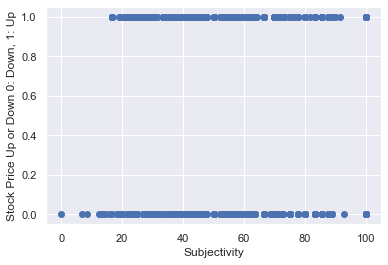

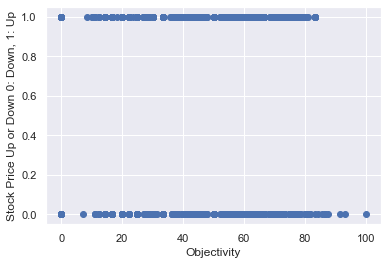

TypeError: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='hist')` instead of `Series.plot('hist',)`.

In [41]:
pyplot.scatter(df['Subjectivity'], df['Label'])
pyplot.xlabel('Subjectivity')
pyplot.ylabel('Stock Price Up or Down 0: Down, 1: Up')
pyplot.show()
pyplot.scatter(df['Objectivity'], df['Label'])
pyplot.xlabel('Objectivity')
pyplot.ylabel('Stock Price Up or Down 0: Down, 1: Up')
pyplot.show()
df['Subjectivity'].plot('hist')
pyplot.xlabel('Subjectivity')
pyplot.ylabel('Frequency')
pyplot.show()
df['Objectivity'].plot('hist')
pyplot.xlabel('Subjectivity')
pyplot.ylabel('Frequency')
pyplot.show()
print("Size of the Labels column")
print(df.groupby('Label').size())

In [42]:
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import warnings

bin_col = df.columns
zero_list = []
one_list = []
for col in bin_col:
    zero_count = 0
    one_count = 0
    for ix, val in df[col].iteritems():
        if df.loc[ix, 'Label'] == 0:
            zero_count += 1
        else:
            one_count += 1
    zero_list.append(zero_count)
    one_list.append(one_count)
    
trace1 = go.Bar(
    x=bin_col,
    y=zero_list ,
    name='Zero count'
)
trace2 = go.Bar(
    x=bin_col,
    y=one_list,
    name='One count'
)

data = [trace1, trace2]
layout = go.Layout(
    barmode='stack',
    title='Count of 1 and 0 in binary variables'
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='stacked-bar')

# Training

In [7]:
# Print the datatypes and count of the dataframe
print(df.dtypes)
print(df.count())
# Change the NaN values to the mean value of that column
nan_list = ['Subjectivity', 'Objectivity', 'Positive', 'Negative', 'Neutral']
for col in nan_list:
    df[col] = df[col].fillna(df[col].mean())

# Recheck the count
print(df.count())

Date            datetime64[ns]
Label                    int64
Subjectivity           float64
Objectivity            float64
Positive               float64
Negative               float64
Neutral                float64
cleaned                 object
Open                   float64
High                   float64
Low                    float64
Close                  float64
Volume                   int64
Adj Close              float64
change                 float64
target                   int64
dtype: object
Date            1729
Label           1729
Subjectivity    1729
Objectivity     1729
Positive        1729
Negative        1729
Neutral         1729
cleaned         1729
Open            1729
High            1729
Low             1729
Close           1729
Volume          1729
Adj Close       1729
change          1729
target          1729
dtype: int64
Date            1729
Label           1729
Subjectivity    1729
Objectivity     1729
Positive        1729
Negative        1729
Neutral        

In [35]:
# Separate the dataframe for input(X) and output variables(y)
X = df.loc[:,'Subjectivity':'Adj Close']
y = df.loc[:,'target']

In [36]:
X = X.drop(['cleaned'], axis=1)

In [37]:
X.head(3)

,Subjectivity,Objectivity,Positive,Negative,Neutral,Open,High,Low,Close,Volume,Adj Close
0,75.000000,25.000000,18.750000,56.250000,25.000000,11432.089844,11759.959961,11388.040039,11734.320312,212830000,11734.320312
1,56.250000,43.750000,18.750000,37.500000,43.750000,8637.650391,9026.410156,8637.490234,8934.179688,358970000,8934.179688
2,38.461538,61.538462,15.384615,23.076923,61.538462,11632.809570,11633.780273,11453.339844,11532.959961,182550000,11532.959961


In [38]:
# Set the validation size, i.e the test set to 20%
validation_size = 0.20
# Split the dataset to test and train sets
# Split the initial 70% of the data as training set and the remaining 30% data as the testing set
train_size = int(len(X.index) * 0.7)
print(len(y))
print(train_size)
X_train, X_test = X.loc[0:train_size, :], X.loc[train_size: len(X.index), :]
y_train, y_test = y[0:train_size+1], y.loc[train_size: len(X.index)]
print('Observations: %d' % (len(X.index)))
print('X Training Observations: %d' % (len(X_train.index)))
print('X Testing Observations: %d' % (len(X_test.index)))
print('y Training Observations: %d' % (len(y_train)))
print('y Testing Observations: %d' % (len(y_test)))

1729
1210
Observations: 1729
X Training Observations: 1211
X Testing Observations: 519
y Training Observations: 1211
y Testing Observations: 519


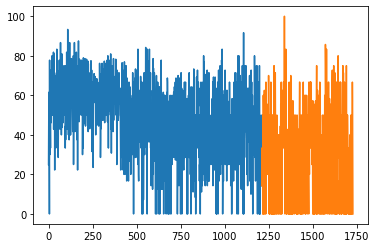

In [39]:
pyplot.plot(X_train['Objectivity'])
pyplot.plot([None for i in X_train['Objectivity']] + [x for x in X_test['Objectivity']])
pyplot.show()

In [23]:
!pip install --upgrade xgboost

Requirement already up-to-date: xgboost in c:\users\henon\.venvs\lewagon\lib\site-packages (1.1.1)


In [40]:
from xgboost import XGBClassifier
num_folds = 10
scoring = 'accuracy'
# Append the models to the models list
models = []
models.append(('LR' , LogisticRegression()))
models.append(('LDA' , LinearDiscriminantAnalysis()))
models.append(('KNN' , KNeighborsClassifier()))
models.append(('CART' , DecisionTreeClassifier()))
models.append(('NB' , GaussianNB()))
models.append(('SVM' , SVC()))
models.append(('RF' , RandomForestClassifier(n_estimators=50)))
models.append(('XGBoost', XGBClassifier()))

In [41]:
# Evaluate each algorithm for accuracy
results = []
names = []
'''
for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=42)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg) '''

for name, model in models:
    clf = model
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accu_score = accuracy_score(y_test, y_pred)
    print(name + ": " + str(accu_score))

LR: 0.5472061657032755
LDA: 0.7996146435452793
KNN: 0.4836223506743738
CART: 0.5144508670520231
NB: 0.5452793834296724
SVM: 0.5472061657032755
RF: 0.5240847784200385
XGBoost: 0.5144508670520231


In [42]:
# prepare the model LDA
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
model_lda = LinearDiscriminantAnalysis()
model_lda.fit(rescaledX, y_train)
# estimate accuracy on validation dataset
rescaledValidationX = scaler.transform(X_test)
predictions = model_lda.predict(rescaledValidationX)
print("accuracy score:")
print(accuracy_score(y_test, predictions))
print("confusion matrix: ")
print(confusion_matrix(y_test, predictions))
print("classification report: ")
print(classification_report(y_test, predictions))

model_xgb = XGBClassifier()
model_xgb.fit(rescaledX, y_train)
# estimate accuracy on validation dataset
rescaledValidationX = scaler.transform(X_test)
predictions = model_xgb.predict(rescaledValidationX)
print("accuracy score:")
print(accuracy_score(y_test, predictions))
print("confusion matrix: ")
print(confusion_matrix(y_test, predictions))
print("classification report: ")
print(classification_report(y_test, predictions))

accuracy score:
0.7996146435452793
confusion matrix: 
[[174  61]
 [ 43 241]]
classification report: 
              precision    recall  f1-score   support

           0       0.80      0.74      0.77       235
           1       0.80      0.85      0.82       284

    accuracy                           0.80       519
   macro avg       0.80      0.79      0.80       519
weighted avg       0.80      0.80      0.80       519

accuracy score:
0.5144508670520231
confusion matrix: 
[[162  73]
 [179 105]]
classification report: 
              precision    recall  f1-score   support

           0       0.48      0.69      0.56       235
           1       0.59      0.37      0.45       284

    accuracy                           0.51       519
   macro avg       0.53      0.53      0.51       519
weighted avg       0.54      0.51      0.50       519



roc auc is :0.5


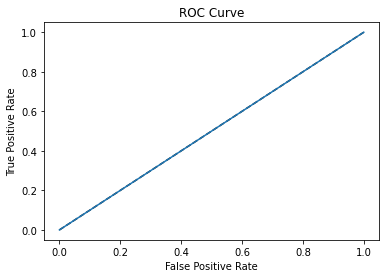

AUC using cross val: [0.8035982  0.78921569 0.91851852 0.76344086 0.86607143 0.9047619
 0.83703704 0.78648233 0.91993464 0.82580645]
Mean AUC score is: 0.8414867063283215


c:\users\henon\.venvs\lewagon\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


In [43]:
# Generating the ROC curve
y_pred_proba = model_lda.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
print("roc auc is :" + str(roc_auc))
pyplot.plot([0, 1], [0, 1], 'k--')
pyplot.plot(fpr, tpr)
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.title('ROC Curve')
pyplot.show()

# AUC score using cross validation
kfold_val = KFold(n_splits=num_folds, random_state=42)
auc_score = cross_val_score(model_lda, X_test, y_test, cv=kfold_val, scoring='roc_auc')
print("AUC using cross val: " + str(auc_score))
mean_auc = np.mean(auc_score)
print("Mean AUC score is: " + str(mean_auc))

In [44]:
# Scaling Random Forests

model_rf = RandomForestClassifier(n_estimators=1000)
model_rf.fit(rescaledX, y_train)
# estimate accuracy on validation dataset
rescaledValidationX = scaler.transform(X_test)
predictions = model_rf.predict(rescaledValidationX)
print("accuracy score:")
print(accuracy_score(y_test, predictions))
print("confusion matrix: ")
print(confusion_matrix(y_test, predictions))
print("classification report: ")
print(classification_report(y_test, predictions))

accuracy score:
0.51252408477842
confusion matrix: 
[[158  77]
 [176 108]]
classification report: 
              precision    recall  f1-score   support

           0       0.47      0.67      0.56       235
           1       0.58      0.38      0.46       284

    accuracy                           0.51       519
   macro avg       0.53      0.53      0.51       519
weighted avg       0.53      0.51      0.50       519



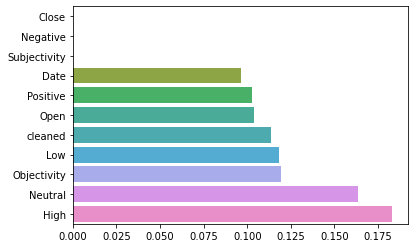

In [55]:
features = df.drop(['Label'],axis=1).columns.values

x, y = (list(x) for x in zip(*sorted(zip(model_xgb.feature_importances_, features), 
                                                            reverse = False)))
graph = sns.barplot(x,y)

In [56]:
# XGBoost on Stock Price dataset, Tune n_estimators and max_depth
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
import matplotlib

matplotlib.use('Agg')
model = XGBClassifier()
n_estimators = [150, 200, 250, 450, 500, 550, 1000]
max_depth = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
print(max_depth)
best_depth = 0
best_estimator = 0
max_score = 0
for n in n_estimators:
    for md in max_depth:
        model = XGBClassifier(n_estimators=n, max_depth=md)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        score = accuracy_score(y_test, y_pred)
        if score > max_score:
            max_score = score
            best_depth = md
            best_estimator = n
        print("Score is " + str(score) + " at depth of " + str(md) + " and estimator " + str(n))
print("Best score is " + str(max_score) + " at depth of " + str(best_depth) + " and estimator of " + str(best_estimator))

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
Score is 0.49710982658959535 at depth of 1 and estimator 150
Score is 0.5337186897880539 at depth of 2 and estimator 150
Score is 0.5337186897880539 at depth of 3 and estimator 150
Score is 0.5144508670520231 at depth of 4 and estimator 150
Score is 0.5279383429672447 at depth of 5 and estimator 150
Score is 0.51252408477842 at depth of 6 and estimator 150
Score is 0.535645472061657 at depth of 7 and estimator 150
Score is 0.5260115606936416 at depth of 8 and estimator 150
Score is 0.5240847784200385 at depth of 9 and estimator 150
Score is 0.535645472061657 at depth of 10 and estimator 150
Score is 0.5298651252408478 at depth of 11 and estimator 150
Score is 0.5221579961464354 at depth of 12 and estimator 150
Score is 0.5067437379576107 at depth of 1 and estimator 200
Score is 0.5394990366088632 at depth of 2 and estimator 200
Score is 0.5337186897880539 at depth of 3 and estimator 200
Score is 0.5337186897880539 at depth of 4 and estimator 200


In [58]:
imp_features_df = df[['Low', "Neutral", 'Close', 'Objectivity', 'Date']]
Xi_train, Xi_test = X.loc[0:train_size, :], X.loc[train_size: len(X.index), :]
clf = XGBClassifier(n_estimators=450, max_depth=10)
clf.fit(Xi_train, y_train)
yi_pred = clf.predict(Xi_test)
score = accuracy_score(y_test, yi_pred)
print("Score is "+ str(score))

Score is 0.5529865125240848


In [59]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
pca.fit(X)
transformed = pca.transform(X)

transformed.shape
print(type(transformed))

<class 'numpy.ndarray'>


In [60]:
pca_df = pd.DataFrame(transformed)

X_train_pca, X_test_pca = pca_df.loc[0:train_size, :], pca_df.loc[train_size: len(X.index), :]

clf = XGBClassifier(n_estimators=500, max_depth=3)
clf.fit(X_train_pca, y_train)
y_pred_pca = clf.predict(X_test_pca)
score = accuracy_score(y_test, y_pred_pca)
print("Score is "+ str(score))

Score is 0.7649325626204239


In [61]:
pca_matrix = confusion_matrix(y_test, y_pred_pca)
pca_report = classification_report(y_test, y_pred_pca)
print("Confusion Matrix: \n" + str(pca_matrix))
print("Classification report: \n" + str(pca_report))

Confusion Matrix: 
[[170  65]
 [ 57 227]]
Classification report: 
              precision    recall  f1-score   support

           0       0.75      0.72      0.74       235
           1       0.78      0.80      0.79       284

    accuracy                           0.76       519
   macro avg       0.76      0.76      0.76       519
weighted avg       0.76      0.76      0.76       519



AUC score is 0.7894216362001798
roc auc is :0.7894216362001798


c:\users\henon\.venvs\lewagon\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  


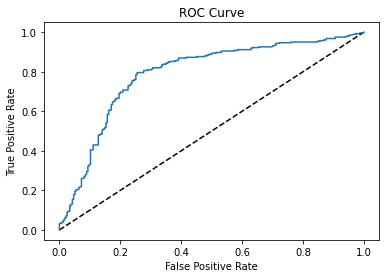

In [62]:
# Generating the ROC curve
y_pred_proba_pca = clf.predict_proba(X_test_pca)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_pca)
roc_auc = auc(fpr, tpr)
print("AUC score is " + str(roc_auc))

# Plot ROC curve
print("roc auc is :" + str(roc_auc))
pyplot.plot([0, 1], [0, 1], 'k--')
pyplot.plot(fpr, tpr)
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.title('ROC Curve')
pyplot.show()

<generator object TimeSeriesSplit.split at 0x000001D2EC5CCA48>
Observations: 865
Training Observations: 433
Testing Observations: 432
Observations: 1297
Training Observations: 865
Testing Observations: 432
Observations: 1729
Training Observations: 1297
Testing Observations: 432
(array([0, 1, 2, 3, 4]), array([5, 6]))


c:\users\henon\.venvs\lewagon\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  from ipykernel import kernelapp as app


TypeError: only integer scalar arrays can be converted to a scalar index

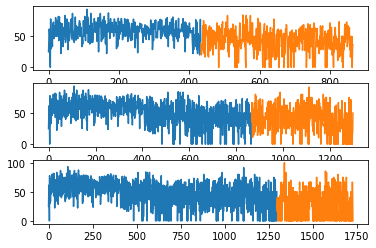

In [63]:
splits = TimeSeriesSplit(n_splits=3)
pyplot.figure(1)
index = 1
print(splits.split(X))
for X_train_index, X_test_index in splits.split(X):
    X1_train = X.loc[X_train_index, :]
    X1_test = X.loc[X_test_index, :]
    print('Observations: %d' % (len(X1_train) + len(X1_test)))
    print('Training Observations: %d' % (len(X1_train)))
    print('Testing Observations: %d' % (len(X1_test)))
    pyplot.subplot(310 + index)
    pyplot.plot(X1_train['Objectivity'])
    pyplot.plot([None for i in X1_train['Objectivity']] + [x for x in X1_test['Objectivity']])
    index += 1
pyplot.show()

index = 1
#y = np.array(y)
y_ser = list(splits.split(y))
print(y_ser[0])
for y_train_index, y_test_index in y_ser:
    y1_train = y[y_train_index]
    y1_test = y[y_test_index]
    print('Observations: %d' % (len(y1_train) + len(y1_test)))
    print('Training Observations: %d' % (len(y1_train)))
    print('Testing Observations: %d' % (len(y1_test)))
    pyplot.subplot(310 + index)
    pyplot.plot(y1_train)
    pyplot.plot([None for i in y1_train] + [x for x in y1_test])
    index += 1
pyplot.show()

In [64]:
# Evaluate each algorithm for accuracy
results = []
names = []

for name, model in models:
    clf1 = model
    clf1.fit(X1_train, y1_train)
    y1_pred = clf.predict(X1_test)
    accu_score1 = accuracy_score(y1_test, y1_pred)
    print(name + ": " + str(accu_score))

NameError: name 'y1_train' is not defined

c:\users\henon\.venvs\lewagon\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  after removing the cwd from sys.path.


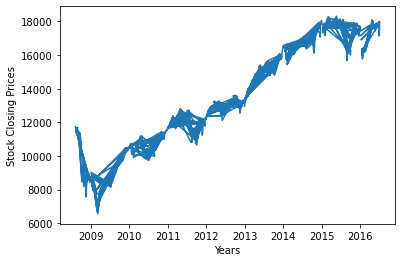

In [65]:
pyplot.plot(df['Date'], df['Close'])
pyplot.xlabel('Years')
pyplot.ylabel('Stock Closing Prices')
pyplot.show()

In [66]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1729 entries, 0 to 1728
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          1729 non-null   datetime64[ns]
 1   Label         1729 non-null   int64         
 2   Subjectivity  1729 non-null   float64       
 3   Objectivity   1729 non-null   float64       
 4   Positive      1729 non-null   float64       
 5   Negative      1729 non-null   float64       
 6   Neutral       1729 non-null   float64       
 7   cleaned       1729 non-null   object        
 8   Open          1729 non-null   float64       
 9   High          1729 non-null   float64       
 10  Low           1729 non-null   float64       
 11  Close         1729 non-null   float64       
 12  Volume        1729 non-null   int64         
 13  Adj Close     1729 non-null   float64       
 14  change        1729 non-null   float64       
 15  target        1729 non-null   int64   

# TPOT

In [67]:
from sklearn.model_selection import train_test_split
import os
from tpot import TPOTClassifier

rescaledValidationX = scaler.transform(X_test)

# instanciate TPOTClassifier
tpot = TPOTClassifier(generations=5, population_size=50, verbosity=2, n_jobs=-1)
# process autoML with TPOT
tpot.fit(X_train, y_train)
# print score
print(tpot.score(rescaledValidationX, y_test))
tpot.export('tpot_stock_pipeline.py')

c:\users\henon\.venvs\lewagon\lib\site-packages\tpot\builtins\__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")



Generation 1 - Current best internal CV score: 0.6028058361391695
Generation 2 - Current best internal CV score: 0.6028058361391695
Generation 3 - Current best internal CV score: 0.6028058361391695
Generation 4 - Current best internal CV score: 0.7910485324626738
Generation 5 - Current best internal CV score: 0.7910485324626738
Best pipeline: LogisticRegression(StandardScaler(input_matrix), C=20.0, dual=False, penalty=l2)
0.5472061657032755


In [68]:
from sklearn.model_selection import train_test_split
import os
from tpot import TPOTClassifier

# instanciate TPOTClassifier
rescaledValidationX = scaler.transform(X_test)

tpot = TPOTClassifier(verbosity=3, scoring='accuracy', random_state=32,  n_jobs=-1, generations=5, population_size=100)

# process autoML with TPOT
tpot.fit(X_train, y_train)
# print score
print(tpot.score(rescaledValidationX, y_test))
tpot.export('tpot_stock_pipeline.py')

32 operators have been imported by TPOT.


_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required..
_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=False.
_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required..
_pre_test decorator: _random_mutation_operator: num_test=0 feature_names mismatch: ['Subjectivity', 'Objectivity', 'Positive', 'Negative', 'Neutral', 'Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close'] ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10']
expected Open, Subjectivity, Adj Close, Neutral, Close, Low, Objectivity, High, Volume, Negative, Positive in input data
training data did not have the following fields: f5, f2, f10, f8, f6, f7, f9, f0, f3, f4, f1.
_pre_test decorator: _ra

_pre_test decorator: _random_mutation_operator: num_test=0 feature_names mismatch: ['Subjectivity', 'Objectivity', 'Positive', 'Negative', 'Neutral', 'Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close'] ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10']
expected Open, Subjectivity, Adj Close, Neutral, Close, Low, Objectivity, High, Volume, Negative, Positive in input data
training data did not have the following fields: f5, f2, f10, f8, f6, f7, f9, f0, f3, f4, f1.
_pre_test decorator: _random_mutation_operator: num_test=0 '(slice(None, None, None), 0)' is an invalid key.
_pre_test decorator: _random_mutation_operator: num_test=0 feature_names mismatch: ['Subjectivity', 'Objectivity', 'Positive', 'Negative', 'Neutral', 'Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close'] ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10']
expected Open, Subjectivity, Adj Close, Neutral, Close, Low, Objectivity, High, Volume, Negative, Positive in input data
training 

_pre_test decorator: _random_mutation_operator: num_test=0 Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty..
_pre_test decorator: _random_mutation_operator: num_test=0 Solver lbfgs supports only dual=False, got dual=True.
_pre_test decorator: _random_mutation_operator: num_test=0 array must not contain infs or NaNs.
Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.
Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.
Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.

Generation 5 - Current Pareto front scores:
-1	0.6432574907322383	LinearSVC(CombineDFs(input_matrix, input_matrix), LinearSVC__C=5.0, LinearSVC__dual=False, LinearSVC__loss=squared_hinge, LinearSVC__penalty=l1, LinearSVC__tol=1e-05)
-2	0.8141992313709485	X

In [71]:
tpot = TPOTClassifier()
tpot.fit(X_train, y_train)
tpot.score(X_test, y_test)
tpot.export('tpot_stock_pipeline.py')

In [72]:
from sklearn.model_selection import train_test_split
import os
from tpot import TPOTClassifier

# instanciate TPOTClassifier
tpot = TPOTClassifier(generations=100, population_size=100, verbosity=2, n_jobs=-1)
# process autoML with TPOT
tpot.fit(X_train, y_train)
# print score
print(tpot.score(X_test, y_test))
tpot.export('tpot_stock_pipeline.py')


Generation 1 - Current best internal CV score: 0.8175016154814134
Generation 2 - Current best internal CV score: 0.8183280617624051
Generation 3 - Current best internal CV score: 0.8183280617624051
Generation 4 - Current best internal CV score: 0.8183280617624051
Generation 5 - Current best internal CV score: 0.8183280617624051
Generation 6 - Current best internal CV score: 0.8183280617624051
Generation 7 - Current best internal CV score: 0.8183280617624051
Generation 8 - Current best internal CV score: 0.8191477060163928
Generation 9 - Current best internal CV score: 0.8191477060163928
Generation 10 - Current best internal CV score: 0.8224466891133557
Generation 11 - Current best internal CV score: 0.8224466891133557
Generation 12 - Current best internal CV score: 0.8224466891133557
Generation 13 - Current best internal CV score: 0.8224466891133557
Generation 14 - Current best internal CV score: 0.8257592762643269
Generation 15 - Current best internal CV score: 0.8257592762643269
Gen

In [73]:
from sklearn.model_selection import train_test_split
import os
from tpot import TPOTClassifier

# instanciate TPOTClassifier
tpot = TPOTClassifier(generations=100, population_size=100, verbosity=2, n_jobs=-1)
# process autoML with TPOT
tpot.fit(X_train, y_train)
# print score
print(tpot.score(X_test, y_test))
tpot.export('tpot_stock_pipeline.py')


Generation 1 - Current best internal CV score: 0.8175084175084175
Generation 2 - Current best internal CV score: 0.8216236438458662
Generation 3 - Current best internal CV score: 0.8216236438458662
Generation 4 - Current best internal CV score: 0.8216236438458662
Generation 5 - Current best internal CV score: 0.8216270448593681
Generation 6 - Current best internal CV score: 0.8216270448593681
Generation 7 - Current best internal CV score: 0.8232799374213515
Generation 8 - Current best internal CV score: 0.8232799374213515
Generation 9 - Current best internal CV score: 0.8232799374213515
Generation 10 - Current best internal CV score: 0.8232799374213515
Generation 11 - Current best internal CV score: 0.8265721184913104
Generation 12 - Current best internal CV score: 0.8307145529367752
Generation 13 - Current best internal CV score: 0.8307145529367752
Generation 14 - Current best internal CV score: 0.8307145529367752
Generation 15 - Current best internal CV score: 0.8307145529367752
Gen

## Doc similarity

In [ ]:
text1

In [ ]:
other = df[13:]

In [ ]:
# Program to measure similarity between  
# two sentences using cosine similarity. 
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 

def similarity(text2):
    text1 = df['cleaned'][10]
    # tokenization 
    X_list = word_tokenize(text1)  
    Y_list = word_tokenize(text2) 
  
    # sw contains the list of stopwords 
    sw = stopwords.words('english')  
    l1 =[];l2 =[] 
  
    # remove stop words from string 
    X_set = {w for w in X_list if not w in sw}  
    Y_set = {w for w in Y_list if not w in sw} 
  
    # form a set containing keywords of both strings  
    rvector = X_set.union(Y_set)  
    for w in rvector: 
        if w in X_set: l1.append(1) # create a vector 
        else: l1.append(0) 
        if w in Y_set: l2.append(1) 
        else: l2.append(0) 
    c = 0
  
    # cosine formula  
    for i in range(len(rvector)): 
            c+= l1[i]*l2[i] 
    cosine = c / float((sum(l1)*sum(l2))**0.5) 
    return cosine
similarity(text2)

In [ ]:
other['similarity'] = df['cleaned'].apply(similarity)

https://www.geeksforgeeks.org/python-measure-similarity-between-two-sentences-using-cosine-similarity/

In [ ]:
def invest():
    index = other[other['similarity'] == other['similarity'].max()].index[0]
    target = df['target'][index]
    if target == 1:
        print('It smells like money')
    if target == 0:
        print('you better buy your girlfriend a present than invest')
    print(index)
    print(target)


invest()

## Reddit news scrapping

In [ ]:
import datetime as dt
import json
import requests

text = []
today = dt.datetime.combine(dt.date.today(), dt.datetime.min.time())
response = requests.get('https://www.reddit.com/r/worldnews/top.json?limit=25', headers = {'User-agent': 'test'})
tops = json.loads(response.text)['data']['children']
for top in tops:
  if dt.datetime.fromtimestamp(top['data']['created']) >= today:
    text.append(top['data']['title'])
  else:
    text.append(top['data']['created'])

full = clean("".join(str(text)))
new_df = pd.DataFrame(data, columns = ['Date', 'cleaned'])
new_df

## Yahoo finance scrapping

In [ ]:
import requests
from bs4 import BeautifulSoup


URL = 'https://finance.yahoo.com/quote/%5EDJI/history?p=%5EDJI'
page = requests.get(URL)
soup = BeautifulSoup(page.content, 'html.parser')


In [ ]:
from alpha_vantage.timeseries import TimeSeries

In [ ]:
<table class="W(100%) M(0)" data-test="historical-prices"><thead><tr class="C($tertiaryColor) Fz(xs) Ta(end)"><th class="Ta(start) W(100px) Fw(400) Py(6px)"><span>Date</span></th><th class="Fw(400) Py(6px)"><span>Open</span></th><th class="Fw(400) Py(6px)"><span>High</span></th><th class="Fw(400) Py(6px)"><span>Low</span></th><th class="Fw(400) Py(6px)"><span>Close*</span></th><th class="Fw(400) Py(6px)"><span>Adj Close**</span></th><th class="Fw(400) Py(6px)"><span>Volume</span></th></tr></thead><tbody><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Jun 25, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>25,365.22</span></td><td class="Py(10px) Pstart(10px)"><span>25,769.61</span></td><td class="Py(10px) Pstart(10px)"><span>25,209.79</span></td><td class="Py(10px) Pstart(10px)"><span>25,745.60</span></td><td class="Py(10px) Pstart(10px)"><span>25,745.60</span></td><td class="Py(10px) Pstart(10px)"><span>384,560,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Jun 24, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>25,992.96</span></td><td class="Py(10px) Pstart(10px)"><span>25,992.96</span></td><td class="Py(10px) Pstart(10px)"><span>25,296.73</span></td><td class="Py(10px) Pstart(10px)"><span>25,445.94</span></td><td class="Py(10px) Pstart(10px)"><span>25,445.94</span></td><td class="Py(10px) Pstart(10px)"><span>450,120,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Jun 23, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>26,159.39</span></td><td class="Py(10px) Pstart(10px)"><span>26,314.97</span></td><td class="Py(10px) Pstart(10px)"><span>26,105.97</span></td><td class="Py(10px) Pstart(10px)"><span>26,156.10</span></td><td class="Py(10px) Pstart(10px)"><span>26,156.10</span></td><td class="Py(10px) Pstart(10px)"><span>389,980,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Jun 22, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>25,865.08</span></td><td class="Py(10px) Pstart(10px)"><span>26,059.81</span></td><td class="Py(10px) Pstart(10px)"><span>25,667.68</span></td><td class="Py(10px) Pstart(10px)"><span>26,024.96</span></td><td class="Py(10px) Pstart(10px)"><span>26,024.96</span></td><td class="Py(10px) Pstart(10px)"><span>351,780,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Jun 19, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>26,213.10</span></td><td class="Py(10px) Pstart(10px)"><span>26,451.44</span></td><td class="Py(10px) Pstart(10px)"><span>25,759.66</span></td><td class="Py(10px) Pstart(10px)"><span>25,871.46</span></td><td class="Py(10px) Pstart(10px)"><span>25,871.46</span></td><td class="Py(10px) Pstart(10px)"><span>669,390,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Jun 18, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>26,016.45</span></td><td class="Py(10px) Pstart(10px)"><span>26,154.20</span></td><td class="Py(10px) Pstart(10px)"><span>25,848.53</span></td><td class="Py(10px) Pstart(10px)"><span>26,080.10</span></td><td class="Py(10px) Pstart(10px)"><span>26,080.10</span></td><td class="Py(10px) Pstart(10px)"><span>328,390,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Jun 17, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>26,330.52</span></td><td class="Py(10px) Pstart(10px)"><span>26,400.07</span></td><td class="Py(10px) Pstart(10px)"><span>26,068.41</span></td><td class="Py(10px) Pstart(10px)"><span>26,119.61</span></td><td class="Py(10px) Pstart(10px)"><span>26,119.61</span></td><td class="Py(10px) Pstart(10px)"><span>328,830,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Jun 16, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>26,326.68</span></td><td class="Py(10px) Pstart(10px)"><span>26,611.03</span></td><td class="Py(10px) Pstart(10px)"><span>25,811.70</span></td><td class="Py(10px) Pstart(10px)"><span>26,289.98</span></td><td class="Py(10px) Pstart(10px)"><span>26,289.98</span></td><td class="Py(10px) Pstart(10px)"><span>489,500,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Jun 15, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>25,270.39</span></td><td class="Py(10px) Pstart(10px)"><span>25,891.58</span></td><td class="Py(10px) Pstart(10px)"><span>24,843.18</span></td><td class="Py(10px) Pstart(10px)"><span>25,763.16</span></td><td class="Py(10px) Pstart(10px)"><span>25,763.16</span></td><td class="Py(10px) Pstart(10px)"><span>461,230,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Jun 12, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>25,659.42</span></td><td class="Py(10px) Pstart(10px)"><span>25,965.55</span></td><td class="Py(10px) Pstart(10px)"><span>25,078.41</span></td><td class="Py(10px) Pstart(10px)"><span>25,605.54</span></td><td class="Py(10px) Pstart(10px)"><span>25,605.54</span></td><td class="Py(10px) Pstart(10px)"><span>514,440,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Jun 11, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>26,282.51</span></td><td class="Py(10px) Pstart(10px)"><span>26,294.08</span></td><td class="Py(10px) Pstart(10px)"><span>25,082.72</span></td><td class="Py(10px) Pstart(10px)"><span>25,128.17</span></td><td class="Py(10px) Pstart(10px)"><span>25,128.17</span></td><td class="Py(10px) Pstart(10px)"><span>647,780,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Jun 10, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>27,251.89</span></td><td class="Py(10px) Pstart(10px)"><span>27,355.22</span></td><td class="Py(10px) Pstart(10px)"><span>26,938.05</span></td><td class="Py(10px) Pstart(10px)"><span>26,989.99</span></td><td class="Py(10px) Pstart(10px)"><span>26,989.99</span></td><td class="Py(10px) Pstart(10px)"><span>448,930,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Jun 09, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>27,447.37</span></td><td class="Py(10px) Pstart(10px)"><span>27,447.37</span></td><td class="Py(10px) Pstart(10px)"><span>27,151.06</span></td><td class="Py(10px) Pstart(10px)"><span>27,272.30</span></td><td class="Py(10px) Pstart(10px)"><span>27,272.30</span></td><td class="Py(10px) Pstart(10px)"><span>381,430,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Jun 08, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>27,232.93</span></td><td class="Py(10px) Pstart(10px)"><span>27,580.21</span></td><td class="Py(10px) Pstart(10px)"><span>27,232.48</span></td><td class="Py(10px) Pstart(10px)"><span>27,572.44</span></td><td class="Py(10px) Pstart(10px)"><span>27,572.44</span></td><td class="Py(10px) Pstart(10px)"><span>430,200,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Jun 05, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>26,836.80</span></td><td class="Py(10px) Pstart(10px)"><span>27,338.30</span></td><td class="Py(10px) Pstart(10px)"><span>26,836.80</span></td><td class="Py(10px) Pstart(10px)"><span>27,110.98</span></td><td class="Py(10px) Pstart(10px)"><span>27,110.98</span></td><td class="Py(10px) Pstart(10px)"><span>542,310,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Jun 04, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>26,226.49</span></td><td class="Py(10px) Pstart(10px)"><span>26,384.10</span></td><td class="Py(10px) Pstart(10px)"><span>26,082.31</span></td><td class="Py(10px) Pstart(10px)"><span>26,281.82</span></td><td class="Py(10px) Pstart(10px)"><span>26,281.82</span></td><td class="Py(10px) Pstart(10px)"><span>372,190,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Jun 03, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>25,906.88</span></td><td class="Py(10px) Pstart(10px)"><span>26,337.75</span></td><td class="Py(10px) Pstart(10px)"><span>25,906.88</span></td><td class="Py(10px) Pstart(10px)"><span>26,269.89</span></td><td class="Py(10px) Pstart(10px)"><span>26,269.89</span></td><td class="Py(10px) Pstart(10px)"><span>398,790,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Jun 02, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>25,582.52</span></td><td class="Py(10px) Pstart(10px)"><span>25,743.13</span></td><td class="Py(10px) Pstart(10px)"><span>25,523.74</span></td><td class="Py(10px) Pstart(10px)"><span>25,742.65</span></td><td class="Py(10px) Pstart(10px)"><span>25,742.65</span></td><td class="Py(10px) Pstart(10px)"><span>352,610,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Jun 01, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>25,342.99</span></td><td class="Py(10px) Pstart(10px)"><span>25,508.83</span></td><td class="Py(10px) Pstart(10px)"><span>25,220.66</span></td><td class="Py(10px) Pstart(10px)"><span>25,475.02</span></td><td class="Py(10px) Pstart(10px)"><span>25,475.02</span></td><td class="Py(10px) Pstart(10px)"><span>338,310,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>May 29, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>25,324.15</span></td><td class="Py(10px) Pstart(10px)"><span>25,482.80</span></td><td class="Py(10px) Pstart(10px)"><span>25,031.67</span></td><td class="Py(10px) Pstart(10px)"><span>25,383.11</span></td><td class="Py(10px) Pstart(10px)"><span>25,383.11</span></td><td class="Py(10px) Pstart(10px)"><span>527,620,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>May 28, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>25,697.36</span></td><td class="Py(10px) Pstart(10px)"><span>25,758.79</span></td><td class="Py(10px) Pstart(10px)"><span>25,358.73</span></td><td class="Py(10px) Pstart(10px)"><span>25,400.64</span></td><td class="Py(10px) Pstart(10px)"><span>25,400.64</span></td><td class="Py(10px) Pstart(10px)"><span>377,800,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>May 27, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>25,298.63</span></td><td class="Py(10px) Pstart(10px)"><span>25,551.56</span></td><td class="Py(10px) Pstart(10px)"><span>25,009.87</span></td><td class="Py(10px) Pstart(10px)"><span>25,548.27</span></td><td class="Py(10px) Pstart(10px)"><span>25,548.27</span></td><td class="Py(10px) Pstart(10px)"><span>411,230,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>May 26, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>24,781.84</span></td><td class="Py(10px) Pstart(10px)"><span>25,176.42</span></td><td class="Py(10px) Pstart(10px)"><span>24,781.84</span></td><td class="Py(10px) Pstart(10px)"><span>24,995.11</span></td><td class="Py(10px) Pstart(10px)"><span>24,995.11</span></td><td class="Py(10px) Pstart(10px)"><span>424,380,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>May 22, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>24,461.98</span></td><td class="Py(10px) Pstart(10px)"><span>24,481.64</span></td><td class="Py(10px) Pstart(10px)"><span>24,294.07</span></td><td class="Py(10px) Pstart(10px)"><span>24,465.16</span></td><td class="Py(10px) Pstart(10px)"><span>24,465.16</span></td><td class="Py(10px) Pstart(10px)"><span>255,660,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>May 21, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>24,564.27</span></td><td class="Py(10px) Pstart(10px)"><span>24,718.46</span></td><td class="Py(10px) Pstart(10px)"><span>24,370.88</span></td><td class="Py(10px) Pstart(10px)"><span>24,474.12</span></td><td class="Py(10px) Pstart(10px)"><span>24,474.12</span></td><td class="Py(10px) Pstart(10px)"><span>346,770,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>May 20, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>24,455.94</span></td><td class="Py(10px) Pstart(10px)"><span>24,649.48</span></td><td class="Py(10px) Pstart(10px)"><span>24,455.94</span></td><td class="Py(10px) Pstart(10px)"><span>24,575.90</span></td><td class="Py(10px) Pstart(10px)"><span>24,575.90</span></td><td class="Py(10px) Pstart(10px)"><span>366,510,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>May 19, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>24,577.48</span></td><td class="Py(10px) Pstart(10px)"><span>24,599.50</span></td><td class="Py(10px) Pstart(10px)"><span>24,202.96</span></td><td class="Py(10px) Pstart(10px)"><span>24,206.86</span></td><td class="Py(10px) Pstart(10px)"><span>24,206.86</span></td><td class="Py(10px) Pstart(10px)"><span>374,100,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>May 18, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>24,059.98</span></td><td class="Py(10px) Pstart(10px)"><span>24,708.54</span></td><td class="Py(10px) Pstart(10px)"><span>24,059.98</span></td><td class="Py(10px) Pstart(10px)"><span>24,597.37</span></td><td class="Py(10px) Pstart(10px)"><span>24,597.37</span></td><td class="Py(10px) Pstart(10px)"><span>484,190,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>May 15, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>23,454.83</span></td><td class="Py(10px) Pstart(10px)"><span>23,730.08</span></td><td class="Py(10px) Pstart(10px)"><span>23,354.15</span></td><td class="Py(10px) Pstart(10px)"><span>23,685.42</span></td><td class="Py(10px) Pstart(10px)"><span>23,685.42</span></td><td class="Py(10px) Pstart(10px)"><span>491,510,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>May 14, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>23,049.06</span></td><td class="Py(10px) Pstart(10px)"><span>23,630.86</span></td><td class="Py(10px) Pstart(10px)"><span>22,789.62</span></td><td class="Py(10px) Pstart(10px)"><span>23,625.34</span></td><td class="Py(10px) Pstart(10px)"><span>23,625.34</span></td><td class="Py(10px) Pstart(10px)"><span>472,700,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>May 13, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>23,702.16</span></td><td class="Py(10px) Pstart(10px)"><span>23,708.90</span></td><td class="Py(10px) Pstart(10px)"><span>23,067.64</span></td><td class="Py(10px) Pstart(10px)"><span>23,247.97</span></td><td class="Py(10px) Pstart(10px)"><span>23,247.97</span></td><td class="Py(10px) Pstart(10px)"><span>469,950,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>May 12, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>24,292.84</span></td><td class="Py(10px) Pstart(10px)"><span>24,382.09</span></td><td class="Py(10px) Pstart(10px)"><span>23,761.58</span></td><td class="Py(10px) Pstart(10px)"><span>23,764.78</span></td><td class="Py(10px) Pstart(10px)"><span>23,764.78</span></td><td class="Py(10px) Pstart(10px)"><span>359,480,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>May 11, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>24,256.45</span></td><td class="Py(10px) Pstart(10px)"><span>24,366.21</span></td><td class="Py(10px) Pstart(10px)"><span>24,070.22</span></td><td class="Py(10px) Pstart(10px)"><span>24,221.99</span></td><td class="Py(10px) Pstart(10px)"><span>24,221.99</span></td><td class="Py(10px) Pstart(10px)"><span>352,400,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>May 08, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>24,107.82</span></td><td class="Py(10px) Pstart(10px)"><span>24,349.90</span></td><td class="Py(10px) Pstart(10px)"><span>24,107.05</span></td><td class="Py(10px) Pstart(10px)"><span>24,331.32</span></td><td class="Py(10px) Pstart(10px)"><span>24,331.32</span></td><td class="Py(10px) Pstart(10px)"><span>335,760,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>May 07, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>23,837.21</span></td><td class="Py(10px) Pstart(10px)"><span>24,094.62</span></td><td class="Py(10px) Pstart(10px)"><span>23,834.39</span></td><td class="Py(10px) Pstart(10px)"><span>23,875.89</span></td><td class="Py(10px) Pstart(10px)"><span>23,875.89</span></td><td class="Py(10px) Pstart(10px)"><span>369,890,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>May 06, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>23,978.88</span></td><td class="Py(10px) Pstart(10px)"><span>24,054.59</span></td><td class="Py(10px) Pstart(10px)"><span>23,661.14</span></td><td class="Py(10px) Pstart(10px)"><span>23,664.64</span></td><td class="Py(10px) Pstart(10px)"><span>23,664.64</span></td><td class="Py(10px) Pstart(10px)"><span>377,450,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>May 05, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>23,958.88</span></td><td class="Py(10px) Pstart(10px)"><span>24,169.72</span></td><td class="Py(10px) Pstart(10px)"><span>23,868.91</span></td><td class="Py(10px) Pstart(10px)"><span>23,883.09</span></td><td class="Py(10px) Pstart(10px)"><span>23,883.09</span></td><td class="Py(10px) Pstart(10px)"><span>369,710,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>May 04, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>23,581.55</span></td><td class="Py(10px) Pstart(10px)"><span>23,769.56</span></td><td class="Py(10px) Pstart(10px)"><span>23,361.16</span></td><td class="Py(10px) Pstart(10px)"><span>23,749.76</span></td><td class="Py(10px) Pstart(10px)"><span>23,749.76</span></td><td class="Py(10px) Pstart(10px)"><span>355,360,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>May 01, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>24,120.78</span></td><td class="Py(10px) Pstart(10px)"><span>24,120.78</span></td><td class="Py(10px) Pstart(10px)"><span>23,645.30</span></td><td class="Py(10px) Pstart(10px)"><span>23,723.69</span></td><td class="Py(10px) Pstart(10px)"><span>23,723.69</span></td><td class="Py(10px) Pstart(10px)"><span>418,160,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Apr 30, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>24,585.57</span></td><td class="Py(10px) Pstart(10px)"><span>24,585.57</span></td><td class="Py(10px) Pstart(10px)"><span>24,186.90</span></td><td class="Py(10px) Pstart(10px)"><span>24,345.72</span></td><td class="Py(10px) Pstart(10px)"><span>24,345.72</span></td><td class="Py(10px) Pstart(10px)"><span>478,280,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Apr 29, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>24,490.37</span></td><td class="Py(10px) Pstart(10px)"><span>24,764.77</span></td><td class="Py(10px) Pstart(10px)"><span>24,453.99</span></td><td class="Py(10px) Pstart(10px)"><span>24,633.86</span></td><td class="Py(10px) Pstart(10px)"><span>24,633.86</span></td><td class="Py(10px) Pstart(10px)"><span>455,290,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Apr 28, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>24,357.17</span></td><td class="Py(10px) Pstart(10px)"><span>24,512.24</span></td><td class="Py(10px) Pstart(10px)"><span>24,031.20</span></td><td class="Py(10px) Pstart(10px)"><span>24,101.55</span></td><td class="Py(10px) Pstart(10px)"><span>24,101.55</span></td><td class="Py(10px) Pstart(10px)"><span>400,250,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Apr 27, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>23,866.15</span></td><td class="Py(10px) Pstart(10px)"><span>24,207.65</span></td><td class="Py(10px) Pstart(10px)"><span>23,840.61</span></td><td class="Py(10px) Pstart(10px)"><span>24,133.78</span></td><td class="Py(10px) Pstart(10px)"><span>24,133.78</span></td><td class="Py(10px) Pstart(10px)"><span>389,390,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Apr 24, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>23,628.24</span></td><td class="Py(10px) Pstart(10px)"><span>23,826.00</span></td><td class="Py(10px) Pstart(10px)"><span>23,417.68</span></td><td class="Py(10px) Pstart(10px)"><span>23,775.27</span></td><td class="Py(10px) Pstart(10px)"><span>23,775.27</span></td><td class="Py(10px) Pstart(10px)"><span>376,020,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Apr 23, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>23,543.09</span></td><td class="Py(10px) Pstart(10px)"><span>23,885.36</span></td><td class="Py(10px) Pstart(10px)"><span>23,483.35</span></td><td class="Py(10px) Pstart(10px)"><span>23,515.26</span></td><td class="Py(10px) Pstart(10px)"><span>23,515.26</span></td><td class="Py(10px) Pstart(10px)"><span>389,290,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Apr 22, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>23,437.34</span></td><td class="Py(10px) Pstart(10px)"><span>23,613.10</span></td><td class="Py(10px) Pstart(10px)"><span>23,339.60</span></td><td class="Py(10px) Pstart(10px)"><span>23,475.82</span></td><td class="Py(10px) Pstart(10px)"><span>23,475.82</span></td><td class="Py(10px) Pstart(10px)"><span>352,880,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Apr 21, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>23,365.25</span></td><td class="Py(10px) Pstart(10px)"><span>23,365.25</span></td><td class="Py(10px) Pstart(10px)"><span>22,941.88</span></td><td class="Py(10px) Pstart(10px)"><span>23,018.88</span></td><td class="Py(10px) Pstart(10px)"><span>23,018.88</span></td><td class="Py(10px) Pstart(10px)"><span>485,140,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Apr 20, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>24,095.10</span></td><td class="Py(10px) Pstart(10px)"><span>24,108.69</span></td><td class="Py(10px) Pstart(10px)"><span>23,627.19</span></td><td class="Py(10px) Pstart(10px)"><span>23,650.44</span></td><td class="Py(10px) Pstart(10px)"><span>23,650.44</span></td><td class="Py(10px) Pstart(10px)"><span>423,410,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Apr 17, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>23,817.15</span></td><td class="Py(10px) Pstart(10px)"><span>24,264.21</span></td><td class="Py(10px) Pstart(10px)"><span>23,817.15</span></td><td class="Py(10px) Pstart(10px)"><span>24,242.49</span></td><td class="Py(10px) Pstart(10px)"><span>24,242.49</span></td><td class="Py(10px) Pstart(10px)"><span>525,950,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Apr 16, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>23,543.66</span></td><td class="Py(10px) Pstart(10px)"><span>23,598.08</span></td><td class="Py(10px) Pstart(10px)"><span>23,211.38</span></td><td class="Py(10px) Pstart(10px)"><span>23,537.68</span></td><td class="Py(10px) Pstart(10px)"><span>23,537.68</span></td><td class="Py(10px) Pstart(10px)"><span>471,050,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Apr 15, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>23,600.72</span></td><td class="Py(10px) Pstart(10px)"><span>23,649.72</span></td><td class="Py(10px) Pstart(10px)"><span>23,233.32</span></td><td class="Py(10px) Pstart(10px)"><span>23,504.35</span></td><td class="Py(10px) Pstart(10px)"><span>23,504.35</span></td><td class="Py(10px) Pstart(10px)"><span>437,630,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Apr 14, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>23,690.57</span></td><td class="Py(10px) Pstart(10px)"><span>24,040.58</span></td><td class="Py(10px) Pstart(10px)"><span>23,683.44</span></td><td class="Py(10px) Pstart(10px)"><span>23,949.76</span></td><td class="Py(10px) Pstart(10px)"><span>23,949.76</span></td><td class="Py(10px) Pstart(10px)"><span>485,910,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Apr 13, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>23,698.93</span></td><td class="Py(10px) Pstart(10px)"><span>23,698.93</span></td><td class="Py(10px) Pstart(10px)"><span>23,095.35</span></td><td class="Py(10px) Pstart(10px)"><span>23,390.77</span></td><td class="Py(10px) Pstart(10px)"><span>23,390.77</span></td><td class="Py(10px) Pstart(10px)"><span>394,320,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Apr 09, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>23,690.66</span></td><td class="Py(10px) Pstart(10px)"><span>24,008.99</span></td><td class="Py(10px) Pstart(10px)"><span>23,504.09</span></td><td class="Py(10px) Pstart(10px)"><span>23,719.37</span></td><td class="Py(10px) Pstart(10px)"><span>23,719.37</span></td><td class="Py(10px) Pstart(10px)"><span>566,400,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Apr 08, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>22,893.47</span></td><td class="Py(10px) Pstart(10px)"><span>23,513.40</span></td><td class="Py(10px) Pstart(10px)"><span>22,682.99</span></td><td class="Py(10px) Pstart(10px)"><span>23,433.57</span></td><td class="Py(10px) Pstart(10px)"><span>23,433.57</span></td><td class="Py(10px) Pstart(10px)"><span>472,740,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Apr 07, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>23,537.44</span></td><td class="Py(10px) Pstart(10px)"><span>23,617.24</span></td><td class="Py(10px) Pstart(10px)"><span>22,634.45</span></td><td class="Py(10px) Pstart(10px)"><span>22,653.86</span></td><td class="Py(10px) Pstart(10px)"><span>22,653.86</span></td><td class="Py(10px) Pstart(10px)"><span>594,660,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Apr 06, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>21,693.63</span></td><td class="Py(10px) Pstart(10px)"><span>22,783.45</span></td><td class="Py(10px) Pstart(10px)"><span>21,693.63</span></td><td class="Py(10px) Pstart(10px)"><span>22,679.99</span></td><td class="Py(10px) Pstart(10px)"><span>22,679.99</span></td><td class="Py(10px) Pstart(10px)"><span>610,760,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Apr 03, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>21,285.93</span></td><td class="Py(10px) Pstart(10px)"><span>21,447.81</span></td><td class="Py(10px) Pstart(10px)"><span>20,863.09</span></td><td class="Py(10px) Pstart(10px)"><span>21,052.53</span></td><td class="Py(10px) Pstart(10px)"><span>21,052.53</span></td><td class="Py(10px) Pstart(10px)"><span>450,010,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Apr 02, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>20,819.46</span></td><td class="Py(10px) Pstart(10px)"><span>21,477.77</span></td><td class="Py(10px) Pstart(10px)"><span>20,735.02</span></td><td class="Py(10px) Pstart(10px)"><span>21,413.44</span></td><td class="Py(10px) Pstart(10px)"><span>21,413.44</span></td><td class="Py(10px) Pstart(10px)"><span>529,540,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Apr 01, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>21,227.38</span></td><td class="Py(10px) Pstart(10px)"><span>21,487.24</span></td><td class="Py(10px) Pstart(10px)"><span>20,784.43</span></td><td class="Py(10px) Pstart(10px)"><span>20,943.51</span></td><td class="Py(10px) Pstart(10px)"><span>20,943.51</span></td><td class="Py(10px) Pstart(10px)"><span>506,680,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Mar 31, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>22,208.42</span></td><td class="Py(10px) Pstart(10px)"><span>22,480.37</span></td><td class="Py(10px) Pstart(10px)"><span>21,852.08</span></td><td class="Py(10px) Pstart(10px)"><span>21,917.16</span></td><td class="Py(10px) Pstart(10px)"><span>21,917.16</span></td><td class="Py(10px) Pstart(10px)"><span>571,210,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Mar 30, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>21,678.22</span></td><td class="Py(10px) Pstart(10px)"><span>22,378.09</span></td><td class="Py(10px) Pstart(10px)"><span>21,522.08</span></td><td class="Py(10px) Pstart(10px)"><span>22,327.48</span></td><td class="Py(10px) Pstart(10px)"><span>22,327.48</span></td><td class="Py(10px) Pstart(10px)"><span>545,540,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Mar 27, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>21,898.47</span></td><td class="Py(10px) Pstart(10px)"><span>22,327.57</span></td><td class="Py(10px) Pstart(10px)"><span>21,469.27</span></td><td class="Py(10px) Pstart(10px)"><span>21,636.78</span></td><td class="Py(10px) Pstart(10px)"><span>21,636.78</span></td><td class="Py(10px) Pstart(10px)"><span>588,830,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Mar 26, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>21,468.38</span></td><td class="Py(10px) Pstart(10px)"><span>22,595.06</span></td><td class="Py(10px) Pstart(10px)"><span>21,427.10</span></td><td class="Py(10px) Pstart(10px)"><span>22,552.17</span></td><td class="Py(10px) Pstart(10px)"><span>22,552.17</span></td><td class="Py(10px) Pstart(10px)"><span>705,180,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Mar 25, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>21,050.34</span></td><td class="Py(10px) Pstart(10px)"><span>22,019.93</span></td><td class="Py(10px) Pstart(10px)"><span>20,538.34</span></td><td class="Py(10px) Pstart(10px)"><span>21,200.55</span></td><td class="Py(10px) Pstart(10px)"><span>21,200.55</span></td><td class="Py(10px) Pstart(10px)"><span>796,320,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Mar 24, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>19,722.19</span></td><td class="Py(10px) Pstart(10px)"><span>20,737.70</span></td><td class="Py(10px) Pstart(10px)"><span>19,649.25</span></td><td class="Py(10px) Pstart(10px)"><span>20,704.91</span></td><td class="Py(10px) Pstart(10px)"><span>20,704.91</span></td><td class="Py(10px) Pstart(10px)"><span>799,340,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Mar 23, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>19,028.36</span></td><td class="Py(10px) Pstart(10px)"><span>19,121.01</span></td><td class="Py(10px) Pstart(10px)"><span>18,213.65</span></td><td class="Py(10px) Pstart(10px)"><span>18,591.93</span></td><td class="Py(10px) Pstart(10px)"><span>18,591.93</span></td><td class="Py(10px) Pstart(10px)"><span>787,970,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Mar 20, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>20,253.15</span></td><td class="Py(10px) Pstart(10px)"><span>20,531.26</span></td><td class="Py(10px) Pstart(10px)"><span>19,094.27</span></td><td class="Py(10px) Pstart(10px)"><span>19,173.98</span></td><td class="Py(10px) Pstart(10px)"><span>19,173.98</span></td><td class="Py(10px) Pstart(10px)"><span>872,290,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Mar 19, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>19,830.01</span></td><td class="Py(10px) Pstart(10px)"><span>20,442.63</span></td><td class="Py(10px) Pstart(10px)"><span>19,177.13</span></td><td class="Py(10px) Pstart(10px)"><span>20,087.19</span></td><td class="Py(10px) Pstart(10px)"><span>20,087.19</span></td><td class="Py(10px) Pstart(10px)"><span>780,300,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Mar 18, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>20,188.69</span></td><td class="Py(10px) Pstart(10px)"><span>20,489.33</span></td><td class="Py(10px) Pstart(10px)"><span>18,917.46</span></td><td class="Py(10px) Pstart(10px)"><span>19,898.92</span></td><td class="Py(10px) Pstart(10px)"><span>19,898.92</span></td><td class="Py(10px) Pstart(10px)"><span>871,360,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Mar 17, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>20,487.05</span></td><td class="Py(10px) Pstart(10px)"><span>21,379.35</span></td><td class="Py(10px) Pstart(10px)"><span>19,882.26</span></td><td class="Py(10px) Pstart(10px)"><span>21,237.38</span></td><td class="Py(10px) Pstart(10px)"><span>21,237.38</span></td><td class="Py(10px) Pstart(10px)"><span>793,060,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Mar 16, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>20,917.53</span></td><td class="Py(10px) Pstart(10px)"><span>21,768.28</span></td><td class="Py(10px) Pstart(10px)"><span>20,116.46</span></td><td class="Py(10px) Pstart(10px)"><span>20,188.52</span></td><td class="Py(10px) Pstart(10px)"><span>20,188.52</span></td><td class="Py(10px) Pstart(10px)"><span>770,130,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Mar 13, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>21,973.82</span></td><td class="Py(10px) Pstart(10px)"><span>23,189.76</span></td><td class="Py(10px) Pstart(10px)"><span>21,285.37</span></td><td class="Py(10px) Pstart(10px)"><span>23,185.62</span></td><td class="Py(10px) Pstart(10px)"><span>23,185.62</span></td><td class="Py(10px) Pstart(10px)"><span>843,080,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Mar 12, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>22,184.71</span></td><td class="Py(10px) Pstart(10px)"><span>22,837.95</span></td><td class="Py(10px) Pstart(10px)"><span>21,154.46</span></td><td class="Py(10px) Pstart(10px)"><span>21,200.62</span></td><td class="Py(10px) Pstart(10px)"><span>21,200.62</span></td><td class="Py(10px) Pstart(10px)"><span>908,260,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Mar 11, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>24,604.63</span></td><td class="Py(10px) Pstart(10px)"><span>24,604.63</span></td><td class="Py(10px) Pstart(10px)"><span>23,328.32</span></td><td class="Py(10px) Pstart(10px)"><span>23,553.22</span></td><td class="Py(10px) Pstart(10px)"><span>23,553.22</span></td><td class="Py(10px) Pstart(10px)"><span>663,960,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Mar 10, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>24,453.00</span></td><td class="Py(10px) Pstart(10px)"><span>25,020.99</span></td><td class="Py(10px) Pstart(10px)"><span>23,690.34</span></td><td class="Py(10px) Pstart(10px)"><span>25,018.16</span></td><td class="Py(10px) Pstart(10px)"><span>25,018.16</span></td><td class="Py(10px) Pstart(10px)"><span>654,860,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Mar 09, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>24,992.36</span></td><td class="Py(10px) Pstart(10px)"><span>24,992.36</span></td><td class="Py(10px) Pstart(10px)"><span>23,706.07</span></td><td class="Py(10px) Pstart(10px)"><span>23,851.02</span></td><td class="Py(10px) Pstart(10px)"><span>23,851.02</span></td><td class="Py(10px) Pstart(10px)"><span>750,430,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Mar 06, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>25,457.21</span></td><td class="Py(10px) Pstart(10px)"><span>25,994.38</span></td><td class="Py(10px) Pstart(10px)"><span>25,226.62</span></td><td class="Py(10px) Pstart(10px)"><span>25,864.78</span></td><td class="Py(10px) Pstart(10px)"><span>25,864.78</span></td><td class="Py(10px) Pstart(10px)"><span>599,780,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Mar 05, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>26,671.92</span></td><td class="Py(10px) Pstart(10px)"><span>26,671.92</span></td><td class="Py(10px) Pstart(10px)"><span>25,943.33</span></td><td class="Py(10px) Pstart(10px)"><span>26,121.28</span></td><td class="Py(10px) Pstart(10px)"><span>26,121.28</span></td><td class="Py(10px) Pstart(10px)"><span>477,370,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Mar 04, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>26,383.68</span></td><td class="Py(10px) Pstart(10px)"><span>27,102.34</span></td><td class="Py(10px) Pstart(10px)"><span>26,286.31</span></td><td class="Py(10px) Pstart(10px)"><span>27,090.86</span></td><td class="Py(10px) Pstart(10px)"><span>27,090.86</span></td><td class="Py(10px) Pstart(10px)"><span>457,590,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Mar 03, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>26,762.47</span></td><td class="Py(10px) Pstart(10px)"><span>27,084.59</span></td><td class="Py(10px) Pstart(10px)"><span>25,706.28</span></td><td class="Py(10px) Pstart(10px)"><span>25,917.41</span></td><td class="Py(10px) Pstart(10px)"><span>25,917.41</span></td><td class="Py(10px) Pstart(10px)"><span>647,080,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Mar 02, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>25,590.51</span></td><td class="Py(10px) Pstart(10px)"><span>26,706.17</span></td><td class="Py(10px) Pstart(10px)"><span>25,391.96</span></td><td class="Py(10px) Pstart(10px)"><span>26,703.32</span></td><td class="Py(10px) Pstart(10px)"><span>26,703.32</span></td><td class="Py(10px) Pstart(10px)"><span>637,200,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Feb 28, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>25,270.83</span></td><td class="Py(10px) Pstart(10px)"><span>25,494.24</span></td><td class="Py(10px) Pstart(10px)"><span>24,681.01</span></td><td class="Py(10px) Pstart(10px)"><span>25,409.36</span></td><td class="Py(10px) Pstart(10px)"><span>25,409.36</span></td><td class="Py(10px) Pstart(10px)"><span>915,990,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Feb 27, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>26,526.00</span></td><td class="Py(10px) Pstart(10px)"><span>26,775.31</span></td><td class="Py(10px) Pstart(10px)"><span>25,752.82</span></td><td class="Py(10px) Pstart(10px)"><span>25,766.64</span></td><td class="Py(10px) Pstart(10px)"><span>25,766.64</span></td><td class="Py(10px) Pstart(10px)"><span>664,980,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Feb 26, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>27,159.46</span></td><td class="Py(10px) Pstart(10px)"><span>27,542.78</span></td><td class="Py(10px) Pstart(10px)"><span>26,890.97</span></td><td class="Py(10px) Pstart(10px)"><span>26,957.59</span></td><td class="Py(10px) Pstart(10px)"><span>26,957.59</span></td><td class="Py(10px) Pstart(10px)"><span>472,450,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Feb 25, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>28,037.65</span></td><td class="Py(10px) Pstart(10px)"><span>28,149.20</span></td><td class="Py(10px) Pstart(10px)"><span>26,997.62</span></td><td class="Py(10px) Pstart(10px)"><span>27,081.36</span></td><td class="Py(10px) Pstart(10px)"><span>27,081.36</span></td><td class="Py(10px) Pstart(10px)"><span>513,270,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Feb 24, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>28,402.93</span></td><td class="Py(10px) Pstart(10px)"><span>28,402.93</span></td><td class="Py(10px) Pstart(10px)"><span>27,912.44</span></td><td class="Py(10px) Pstart(10px)"><span>27,960.80</span></td><td class="Py(10px) Pstart(10px)"><span>27,960.80</span></td><td class="Py(10px) Pstart(10px)"><span>452,580,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Feb 21, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>29,146.53</span></td><td class="Py(10px) Pstart(10px)"><span>29,146.53</span></td><td class="Py(10px) Pstart(10px)"><span>28,892.70</span></td><td class="Py(10px) Pstart(10px)"><span>28,992.41</span></td><td class="Py(10px) Pstart(10px)"><span>28,992.41</span></td><td class="Py(10px) Pstart(10px)"><span>311,210,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Feb 20, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>29,296.25</span></td><td class="Py(10px) Pstart(10px)"><span>29,368.45</span></td><td class="Py(10px) Pstart(10px)"><span>28,959.65</span></td><td class="Py(10px) Pstart(10px)"><span>29,219.98</span></td><td class="Py(10px) Pstart(10px)"><span>29,219.98</span></td><td class="Py(10px) Pstart(10px)"><span>287,780,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Feb 19, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>29,312.70</span></td><td class="Py(10px) Pstart(10px)"><span>29,409.09</span></td><td class="Py(10px) Pstart(10px)"><span>29,274.38</span></td><td class="Py(10px) Pstart(10px)"><span>29,348.03</span></td><td class="Py(10px) Pstart(10px)"><span>29,348.03</span></td><td class="Py(10px) Pstart(10px)"><span>240,640,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Feb 18, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>29,282.78</span></td><td class="Py(10px) Pstart(10px)"><span>29,330.16</span></td><td class="Py(10px) Pstart(10px)"><span>29,116.81</span></td><td class="Py(10px) Pstart(10px)"><span>29,232.19</span></td><td class="Py(10px) Pstart(10px)"><span>29,232.19</span></td><td class="Py(10px) Pstart(10px)"><span>256,600,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Feb 14, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>29,440.47</span></td><td class="Py(10px) Pstart(10px)"><span>29,463.04</span></td><td class="Py(10px) Pstart(10px)"><span>29,283.18</span></td><td class="Py(10px) Pstart(10px)"><span>29,398.08</span></td><td class="Py(10px) Pstart(10px)"><span>29,398.08</span></td><td class="Py(10px) Pstart(10px)"><span>231,000,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Feb 13, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>29,436.03</span></td><td class="Py(10px) Pstart(10px)"><span>29,535.40</span></td><td class="Py(10px) Pstart(10px)"><span>29,345.93</span></td><td class="Py(10px) Pstart(10px)"><span>29,423.31</span></td><td class="Py(10px) Pstart(10px)"><span>29,423.31</span></td><td class="Py(10px) Pstart(10px)"><span>291,150,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Feb 12, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>29,406.75</span></td><td class="Py(10px) Pstart(10px)"><span>29,568.57</span></td><td class="Py(10px) Pstart(10px)"><span>29,406.75</span></td><td class="Py(10px) Pstart(10px)"><span>29,551.42</span></td><td class="Py(10px) Pstart(10px)"><span>29,551.42</span></td><td class="Py(10px) Pstart(10px)"><span>309,530,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Feb 11, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>29,390.71</span></td><td class="Py(10px) Pstart(10px)"><span>29,415.39</span></td><td class="Py(10px) Pstart(10px)"><span>29,210.47</span></td><td class="Py(10px) Pstart(10px)"><span>29,276.34</span></td><td class="Py(10px) Pstart(10px)"><span>29,276.34</span></td><td class="Py(10px) Pstart(10px)"><span>279,540,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Feb 10, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>28,995.66</span></td><td class="Py(10px) Pstart(10px)"><span>29,278.07</span></td><td class="Py(10px) Pstart(10px)"><span>28,995.66</span></td><td class="Py(10px) Pstart(10px)"><span>29,276.82</span></td><td class="Py(10px) Pstart(10px)"><span>29,276.82</span></td><td class="Py(10px) Pstart(10px)"><span>250,510,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Feb 07, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>29,286.92</span></td><td class="Py(10px) Pstart(10px)"><span>29,286.92</span></td><td class="Py(10px) Pstart(10px)"><span>29,056.98</span></td><td class="Py(10px) Pstart(10px)"><span>29,102.51</span></td><td class="Py(10px) Pstart(10px)"><span>29,102.51</span></td><td class="Py(10px) Pstart(10px)"><span>252,860,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Feb 06, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>29,388.58</span></td><td class="Py(10px) Pstart(10px)"><span>29,408.05</span></td><td class="Py(10px) Pstart(10px)"><span>29,246.93</span></td><td class="Py(10px) Pstart(10px)"><span>29,379.77</span></td><td class="Py(10px) Pstart(10px)"><span>29,379.77</span></td><td class="Py(10px) Pstart(10px)"><span>263,700,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Feb 05, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>29,048.73</span></td><td class="Py(10px) Pstart(10px)"><span>29,308.89</span></td><td class="Py(10px) Pstart(10px)"><span>29,000.85</span></td><td class="Py(10px) Pstart(10px)"><span>29,290.85</span></td><td class="Py(10px) Pstart(10px)"><span>29,290.85</span></td><td class="Py(10px) Pstart(10px)"><span>357,540,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Feb 04, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>28,696.74</span></td><td class="Py(10px) Pstart(10px)"><span>28,904.88</span></td><td class="Py(10px) Pstart(10px)"><span>28,696.74</span></td><td class="Py(10px) Pstart(10px)"><span>28,807.63</span></td><td class="Py(10px) Pstart(10px)"><span>28,807.63</span></td><td class="Py(10px) Pstart(10px)"><span>332,750,000</span></td></tr></tbody><tfoot><tr class="BdT Bdc($seperatorColor) C($tertiaryColor) H(36px)"><td class="Fz(xs)" colspan="7"><span>*Close price adjusted for splits.</span><span class="Mstart(20px)"><span>**Adjusted close price adjusted for both dividends and splits.</span></span></td></tr></tfoot></table>

In [ ]:
api_key = 'B452V7HACZETN0QU'

In [ ]:
ts = TimeSeries(key=api_key, output_format='pandas')

In [ ]:
import requests

url = "https://apidojo-yahoo-finance-v1.p.rapidapi.com/stock/v2/get-balance-sheet"

querystring = {"symbol":"IBM"}

headers = {
    'x-rapidapi-host': "apidojo-yahoo-finance-v1.p.rapidapi.com",
    'x-rapidapi-key': "617248b2cemsh58dd69fa7cbabbbp1fb61fjsn2faf663508fa"
    }

response = requests.request("GET", url, headers=headers, params=querystring)

print(response.text)

In [ ]:
!pip install yfinance